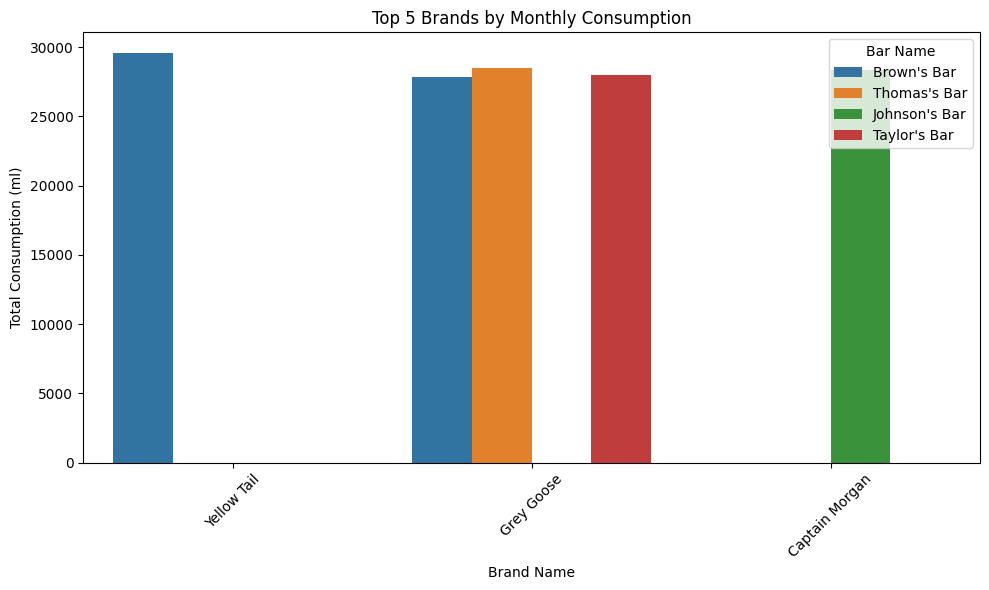

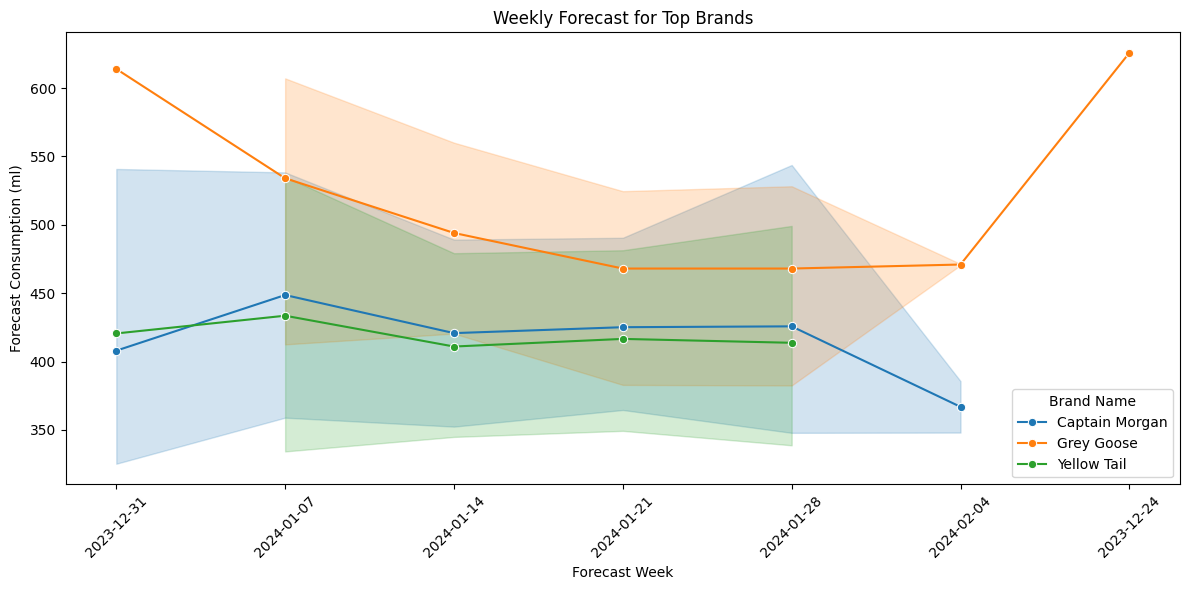

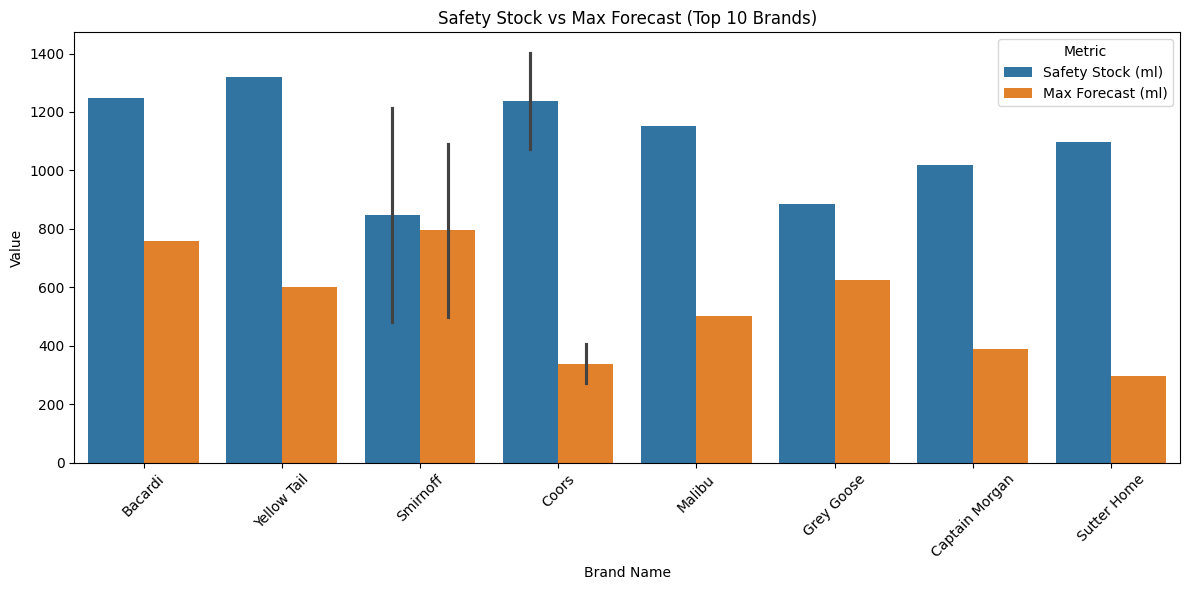

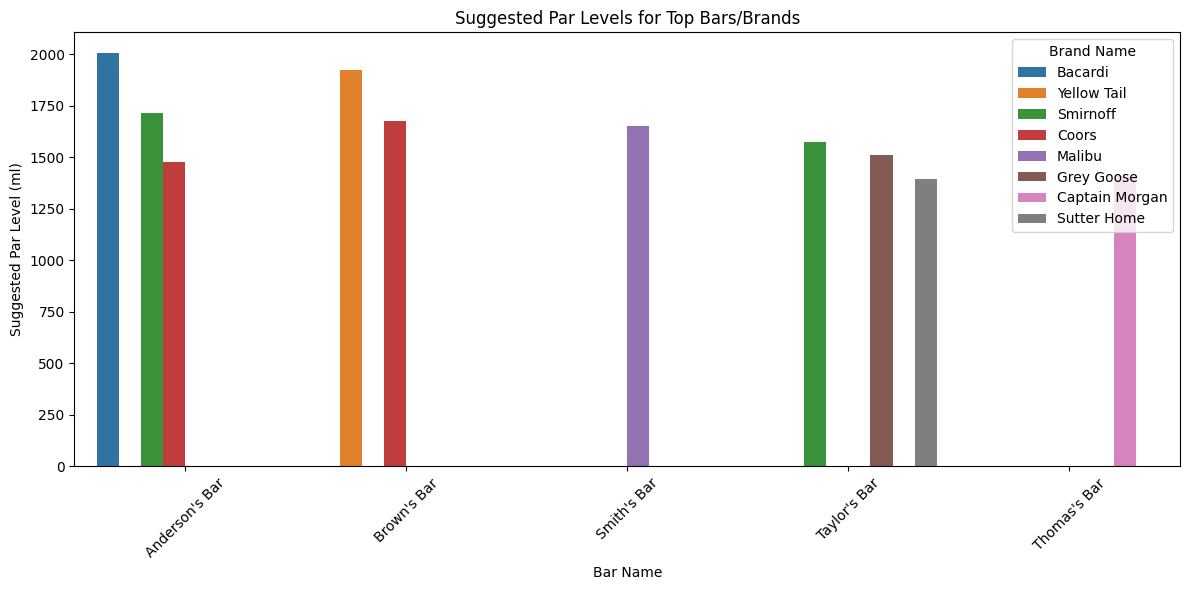

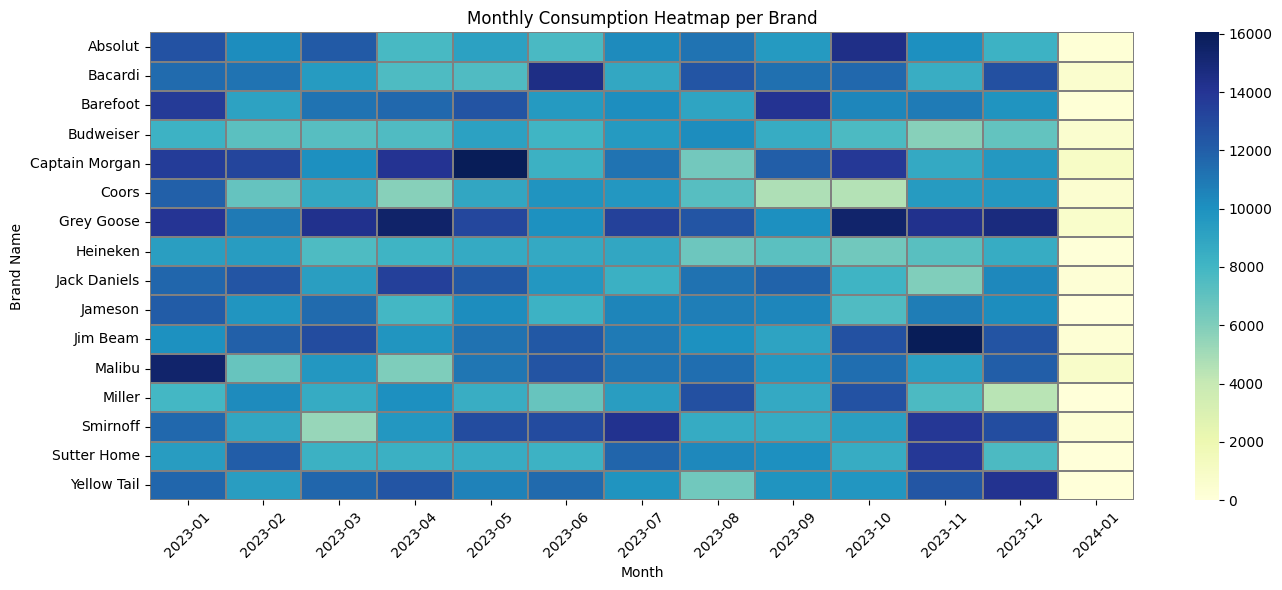

🔮 Weekly Forecast (sample):
         Bar Name Brand Name Forecast Week  Forecast Consumption (ml)
0  Anderson's Bar    Absolut    2024-01-07                     222.17
1  Anderson's Bar    Absolut    2024-01-14                     249.66
2  Anderson's Bar    Absolut    2024-01-21                     253.06
3  Anderson's Bar    Absolut    2024-01-28                     253.48
4  Anderson's Bar    Bacardi    2024-01-07                     758.59
5  Anderson's Bar    Bacardi    2024-01-14                     546.78
6  Anderson's Bar    Bacardi    2024-01-21                     503.52
7  Anderson's Bar    Bacardi    2024-01-28                     494.68
8  Anderson's Bar   Barefoot    2024-01-07                     476.73
9  Anderson's Bar   Barefoot    2024-01-14                     507.36

📆 Monthly Summary (sample):
          Bar Name   Brand Name    Month  Total Consumption (ml)
1159  Thomas's Bar  Yellow Tail  2023-03                    0.00
1160  Thomas's Bar  Yellow Tail  2023-04   

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("Consumption Dataset - Dataset.csv")
df['Date Time Served'] = pd.to_datetime(df['Date Time Served'])

# Storage
weekly_forecasts = []
monthly_summaries = []
par_levels = []

# Group by Bar and Brand
for (bar, brand), group in df.groupby(['Bar Name', 'Brand Name']):
    group = group.copy()
    group.set_index('Date Time Served', inplace=True)
    group.sort_index(inplace=True)

    # Weekly time series
    weekly = group['Consumed (ml)'].resample('W').sum().dropna()

    if len(weekly) < 12:
        continue

    try:
        model = ARIMA(weekly, order=(1,1,1))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=4)

        std_dev = weekly[-4:].std()
        z = 1.65  # 95% confidence
        safety_stock = round(z * std_dev, 2)
        max_forecast = round(forecast.max(), 2)
        par_level = round(max_forecast + safety_stock, 2)

        for date, value in forecast.items():
            weekly_forecasts.append({
                'Bar Name': bar,
                'Brand Name': brand,
                'Forecast Week': date.strftime('%Y-%m-%d'),
                'Forecast Consumption (ml)': round(value, 2)
            })

        monthly = group['Consumed (ml)'].resample('M').sum()
        for date, value in monthly.items():
            monthly_summaries.append({
                'Bar Name': bar,
                'Brand Name': brand,
                'Month': date.strftime('%Y-%m'),
                'Total Consumption (ml)': round(value, 2)
            })

        par_levels.append({
            'Bar Name': bar,
            'Brand Name': brand,
            'Suggested Par Level (ml)': par_level,
            'Safety Stock (ml)': safety_stock,
            'Max Forecast (ml)': max_forecast
        })

    except:
        continue

# Convert to DataFrames
forecast_df = pd.DataFrame(weekly_forecasts)
monthly_df = pd.DataFrame(monthly_summaries)
par_df = pd.DataFrame(par_levels)

# 📊 Charts

# 1. 🔝 Top 5 Brands by Monthly Total Consumption
top5 = (
    monthly_df.groupby(['Bar Name', 'Brand Name'])['Total Consumption (ml)']
    .sum().sort_values(ascending=False).head(5).reset_index()
)

plt.figure(figsize=(10, 6))
sns.barplot(data=top5, x='Brand Name', y='Total Consumption (ml)', hue='Bar Name')
plt.title('Top 5 Brands by Monthly Consumption')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. 📈 Weekly Forecast Line Plot for Top 3 Brands
top_brands = top5['Brand Name'].unique()
forecast_sample = forecast_df[forecast_df['Brand Name'].isin(top_brands)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=forecast_sample, x='Forecast Week', y='Forecast Consumption (ml)', hue='Brand Name', marker='o')
plt.title("Weekly Forecast for Top Brands")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. 🧯 Safety Stock vs Max Forecast
plt.figure(figsize=(12, 6))
top_par = par_df.sort_values(by="Suggested Par Level (ml)", ascending=False).head(10)
top_par_melt = top_par.melt(id_vars=['Brand Name', 'Bar Name'],
                            value_vars=['Safety Stock (ml)', 'Max Forecast (ml)'],
                            var_name='Metric', value_name='Value')
sns.barplot(data=top_par_melt, x='Brand Name', y='Value', hue='Metric')
plt.title("Safety Stock vs Max Forecast (Top 10 Brands)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. 📦 Suggested Par Levels per Bar
plt.figure(figsize=(12, 6))
top_par_bar = par_df.sort_values(by="Suggested Par Level (ml)", ascending=False).head(10)
sns.barplot(data=top_par_bar, x='Bar Name', y='Suggested Par Level (ml)', hue='Brand Name')
plt.title("Suggested Par Levels for Top Bars/Brands")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. 📊 Monthly Heatmap of Consumption per Brand
pivot_table = monthly_df.pivot_table(index='Brand Name', columns='Month', values='Total Consumption (ml)', aggfunc='sum').fillna(0)
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, cmap='YlGnBu', linecolor='gray', linewidths=0.1)
plt.title("Monthly Consumption Heatmap per Brand")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 📋 Show Reports
print("🔮 Weekly Forecast (sample):")
print(forecast_df.head(10))

print("\n📆 Monthly Summary (sample):")
print(monthly_df.tail(10))

print("\n📦 Suggested Par Levels with Safety Stock:")
print(par_df.head(10))
